In [1]:
import cartopy.crs as ccrs
from extractROIfiles import normIm, cartopy_pyresample_toggle_extent,  trasform_cartopy_extent
from extractROIfiles import getPlankConsts, Rad2BT, mat2pandas
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import os
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
#import seaborn as sns
from datetime import datetime
import pandas as pd
from scipy import io as so
import matplotlib as mpl
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10, 6)
#sns.set(style='darkgrid')
%matplotlib inline

In [61]:
def make_mean_BT_fig(g16_xr, g17_xr, temp_df):
    plc = getPlankConsts(g16_xr)
    fig, ax = plt.subplots(figsize=(15,10))
    Rad2BT(g16_xr.Rad.mean(['x','y']), plc).plot(ax=ax,marker='.',
                                                 mfc='r', label='GOES 16')
    Rad2BT(g17_xr.Rad.mean(['x','y']), plc).plot(ax=ax,marker='.',
                                                 mfc='c', label='GOES 17')
    ## This seems like an ugly hack
    ## but != None without string cast complains
    if str(temp_df) != 'None':
        temp_df.plot(ax=ax,mfc='k',label='GOES 17 LWIRTemp')
    ax.set_title('Mean BT in ROI for GOES' + 
                 str(g16_xr.time[0].dt.strftime('%Y %B %d').data))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1/24))
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.set_ylabel('Brightness Temperature')
    ax.set_xlabel('Time')
    ax.legend()
    ax.tick_params('x', labelrotation=45)
    return fig, ax

def make_masked(g_xr, mask, data_key='Rad', mask_key='BCM',flag_value=1.0):
    #### There is a problem here with mis-alignment
    #### Need to uses the time stamps to mask rather
    #### than rely on [] indexing
    cf_xr = g_xr.copy(deep=True)
    cf_xr[data_key].data[mask[mask_key]==flag_value]=np.nan
    return cf_xr

def BT_of_nan_mean_xy(ma_g_xr, plc, target_key, data_key='Rad'):
    N = ma_g_xr[data_key].data.shape[-1]
    return pd.DataFrame({target_key:np.array([
            Rad2BT(np.nanmean(ma_g_xr[data_key].data[:,:,ind]), plc)
                              for ind in range(0,N)])}, 
                      index=ma_g_xr.time.data)

def make_masked_mean_BT_fig(g16_xr, g17_xr, acm16_xr,temp_df ):
    plc = getPlankConsts(g16_xr)
    ma_g16_xr = make_masked(g16_xr, acm16_xr)
    bt_16_df = BT_of_nan_mean_xy(ma_g16_xr, plc, 'G16')
    ma_g17_xr = make_masked(g17_xr, acm16_xr)
    bt_17_df = BT_of_nan_mean_xy(ma_g17_xr, plc, 'G17')
    fig, ax = plt.subplots(figsize=(15,10))
    bt_16_df.plot(ax=ax,marker='.',mfc='c', label='GOES 16')
    bt_17_df.plot(ax=ax,marker='.',mfc='c', label='GOES 17')
    ## This seems like an ugly hack
    ## but != None without string cast complains
    if str(temp_df) != 'None':
        temp_df.plot(ax=ax,mfc='k',label='GOES 17 LWIRTemp')
    ax.set_title('Mean BT in ROI for Clear Sky GOES' + 
                 str(g16_xr.time[0].dt.strftime('%Y %B %d').data))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.set_ylabel('Brightness Temperature')
    ax.set_xlabel('Time')
    ax.legend()
    ax.tick_params('x', labelrotation=45)
    return fig, ax

def get_xarray_data(band=8, day=103,datapath=Path('.'), matfilepath=Path('.')):
    band=str(int(band)).zfill(2)
    fname16 = datapath/Path(f'OR_ABI-L1b-RadF-M6C{band}_G16_s2019{day}_xr.nc')
    if not fname16.exists():
        raise Exception('File does not exist:'+str(fname16))
    fname17 = datapath/Path(f'OR_ABI-L1b-RadF-M6C{band}_G17_s2019{day}_xr.nc')
    if not fname17.exists():
        raise Exception('File does not exist:'+str(fname17))
    acm16fname = datapath/Path(f'OR_ABI-L2-ACMF-M6C00_G16_s2019{day}_xr.nc')
    if not acm16fname.exists():
        raise Exception('File does not exist:'+str(acm16fname))
    day = str(day).zfill(3)
    tempFname = matfilepath/Path(f'INST_CAL_2019{day}.mat')
    if not tempFname.exists():
        print('File does not exit:'+str(tempFname))
        tempFname = None
    g16_xr = xr.load_dataset(fname16)
    g17_xr = xr.load_dataset(fname17)
    acm16_xr = xr.load_dataset(acm16fname)
    if tempFname:
        temp17 = so.loadmat(tempFname)
        temp_df = mat2pandas(temp17)
    else:
        temp_df = None
    return g16_xr, g17_xr, acm16_xr, temp_df

In [55]:
# Laptop paths
datapath = Path('/','mnt','c','Users','michael.GLASSLAB-MODIIN','.Virtualbox',
                'Desktop','roi_fall_data')
matfilepath = Path('/home/michael/dropbox/goesproject/GOESEvalData')
#outputpath = Path('/','mnt','g','GOESProj','data','fall_data')


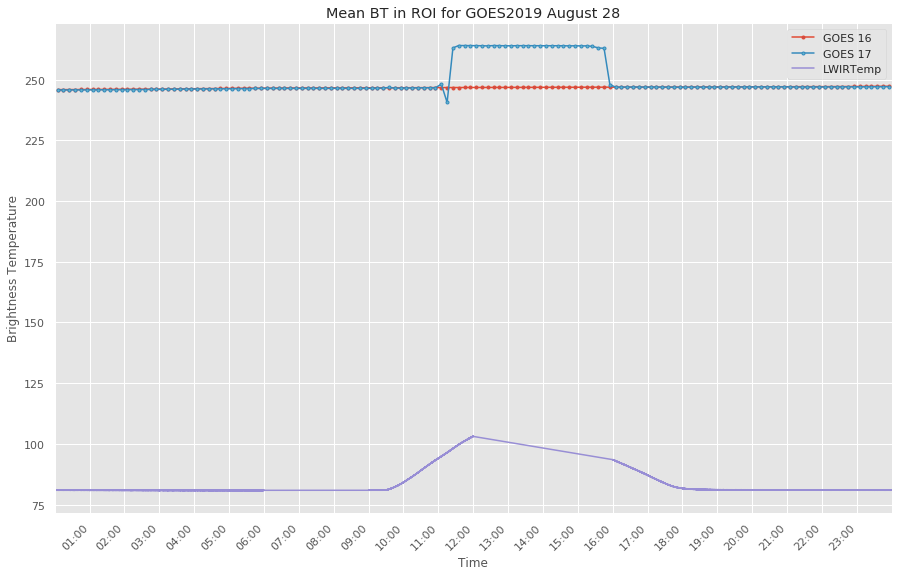

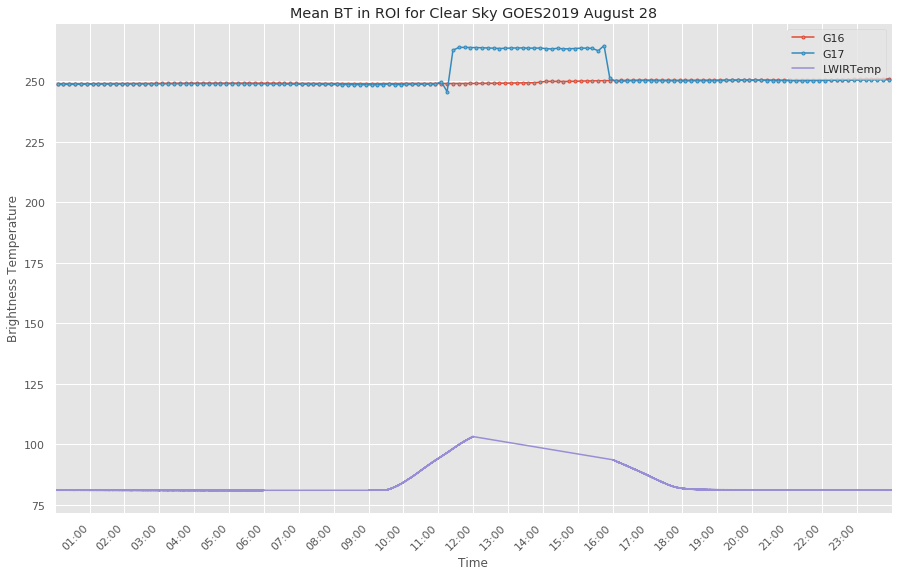

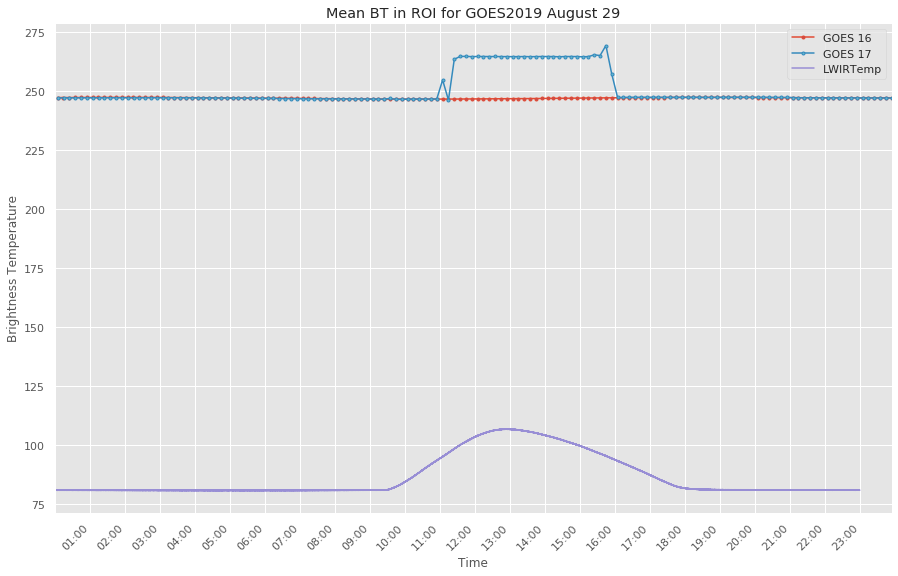

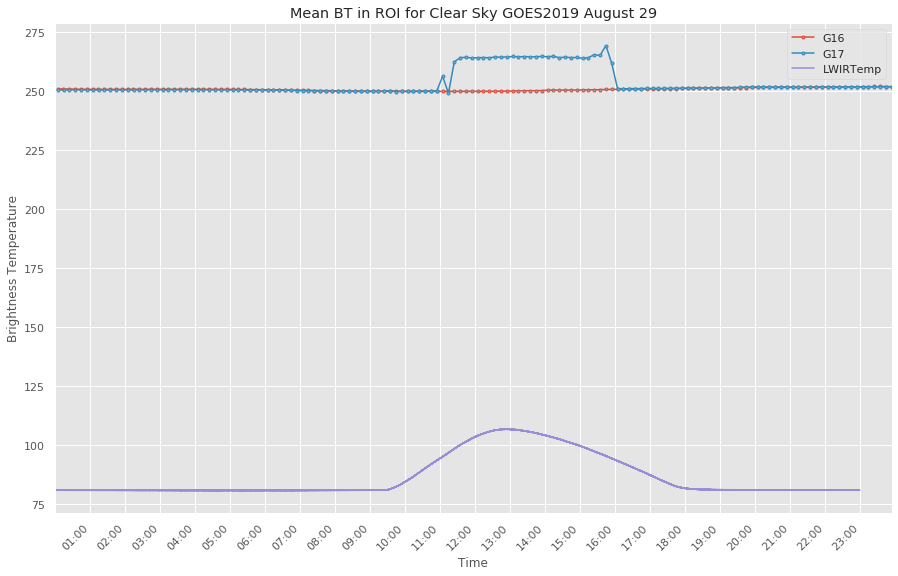

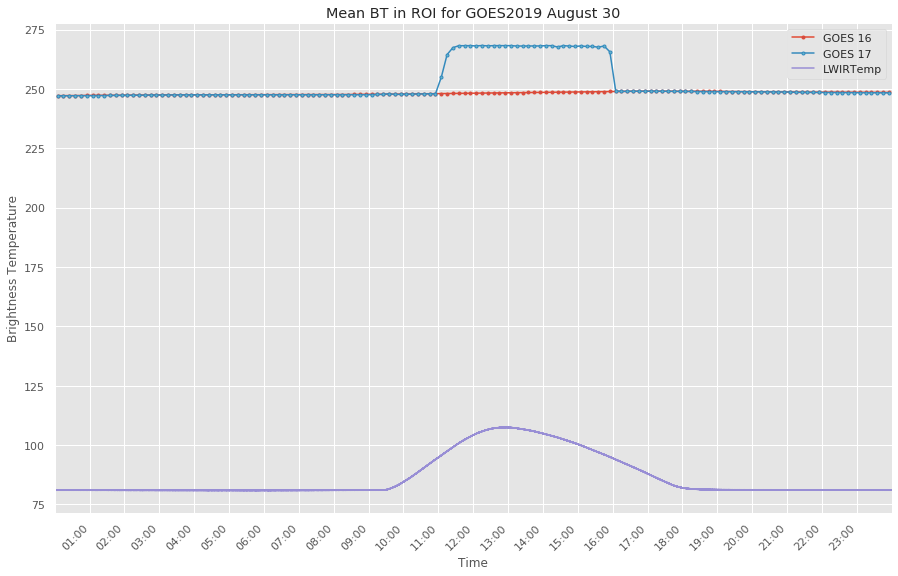

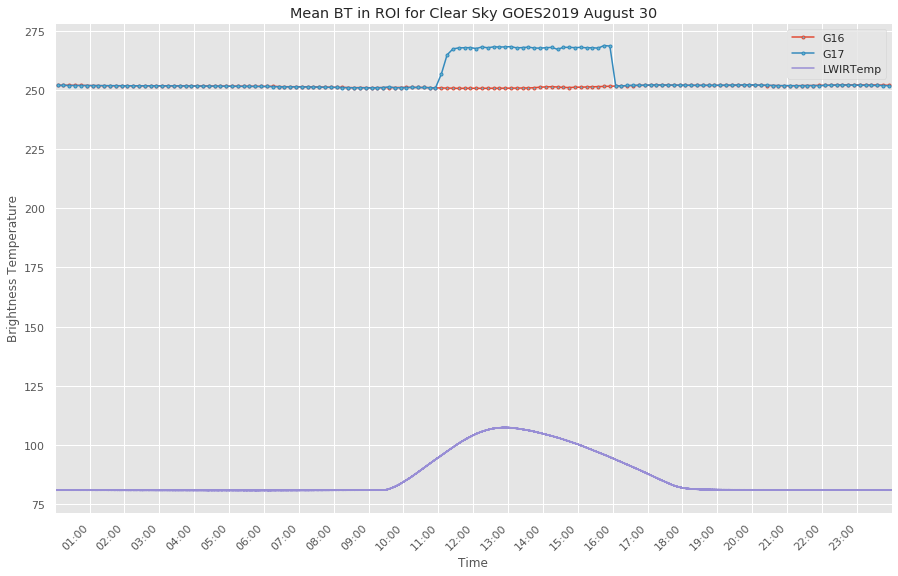

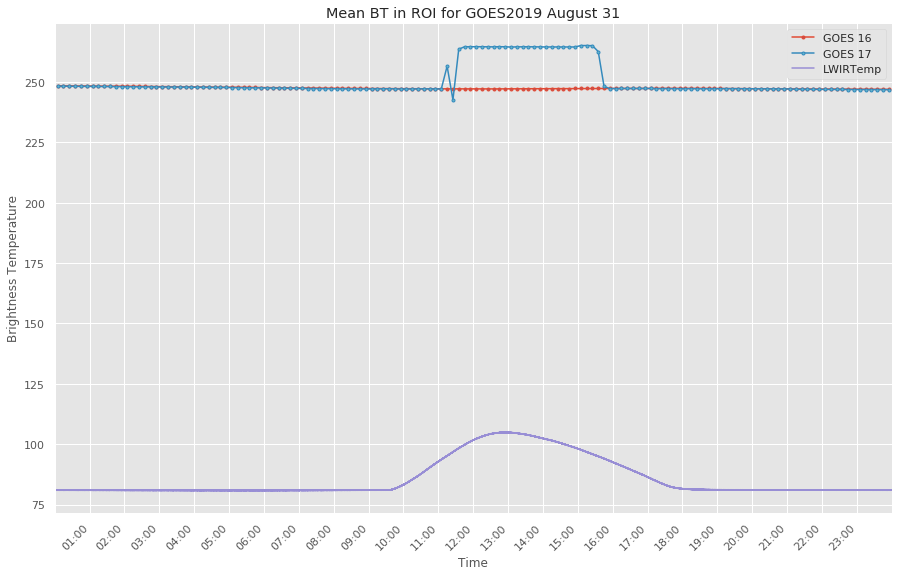

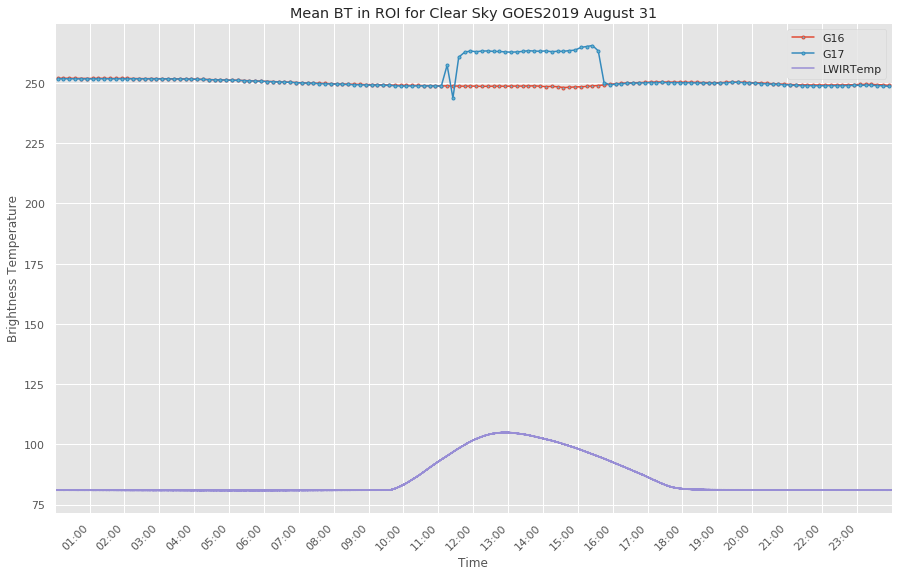

In [62]:
out_dir = Path('./figs')

for day in range(240,244):
    try:
        new16_103_xr, new17_103_xr, acm16_103_xr, temp_df = get_xarray_data(
                    band=8, day=day, 
            datapath=datapath, matfilepath=matfilepath)
        fig, ax = make_mean_BT_fig(new16_103_xr, new17_103_xr, temp_df)
        fig2, ax2 = make_masked_mean_BT_fig(new16_103_xr, 
                                            new17_103_xr, 
                                            acm16_103_xr,
                                            temp_df )
    except Exception as e:
        print('On day '+str(day)+' this happened:' + str(e))

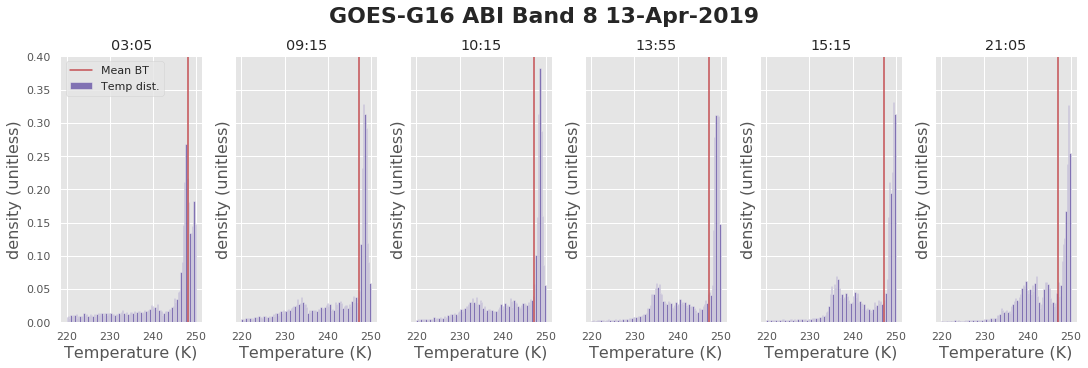

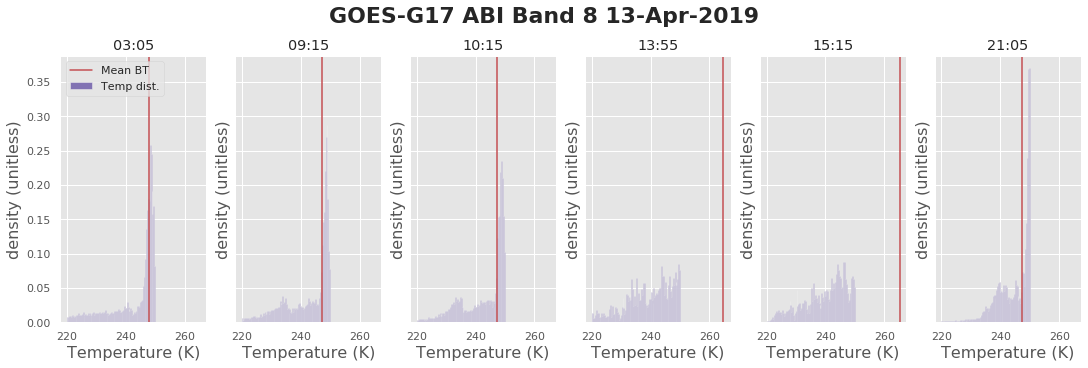

In [65]:
# Still need to make this a function
# two mysteries
# Why are there bars and ghost bars behind the bars???
# Why don't I get blue on one fig and magenta on the other???

# Histograms for full ROI
#toi = ['0300','0910','1010','1350','1510','2100']
toi = ['030','091','101','135','151','210']
bb=8
dd=5
goes_8_xr = {'G16':new16_103_xr, 'G17':new17_103_xr}
bins = np.linspace(220,260,101)
for SS in ['G16','G17']:
    bins = np.linspace(220,250,101)
    fig, axes = plt.subplots(ncols=6, nrows =1, figsize=(15, 5), 
                             constrained_layout=True, sharey = True, 
                             sharex = True)
    fig.suptitle(f'GOES-{SS} ABI Band {bb} {8+dd}-Apr-2019', 
                 fontsize = 22, fontweight = 'bold')
    rois = goes_8_xr[SS].Rad[:,:,[(str(item.data)[:3] in toi)
                for item in goes_8_xr[SS].time.dt.strftime('%H%M')]]
    rois_sz = rois.shape
    for ind in range(rois_sz[2]):
        ax = axes[ind]
        ax.set_title(f'{ind}')
        ax.set_ylabel('density (unitless)',fontsize = 16)
        ax.set_xlabel('Temperature (K)', fontsize = 16)
        ax.set_title(rois[:,:,ind].time.dt.strftime('%H:%M').data)
        ax.hist(Rad2BT(rois[:,:,ind],plc).data.ravel(), 
                                            bins = bins,
                                            color='b' if SS=='16' else 'm',
                                           density = True, 
                                           label = 'Temp dist.')
        ax.axvline(Rad2BT(rois[:,:,ind].mean(['x','y']), plc), 
                   color='r',label = 'Mean BT')
    axes[0].legend(loc='upper left')

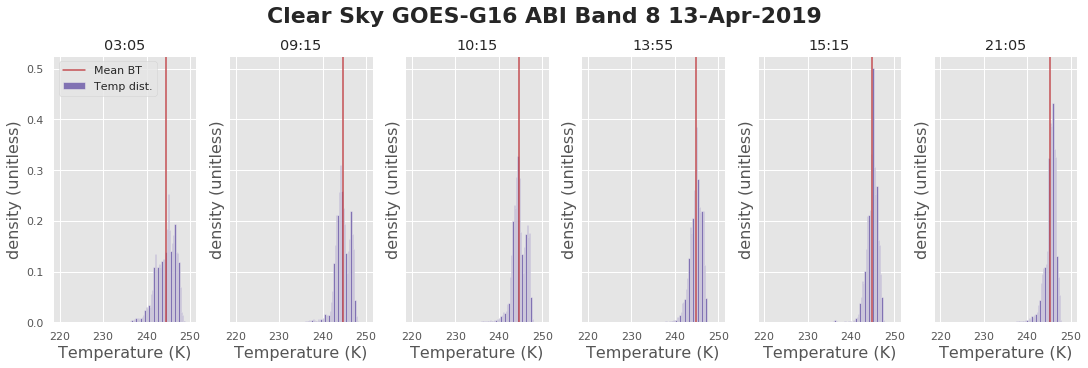

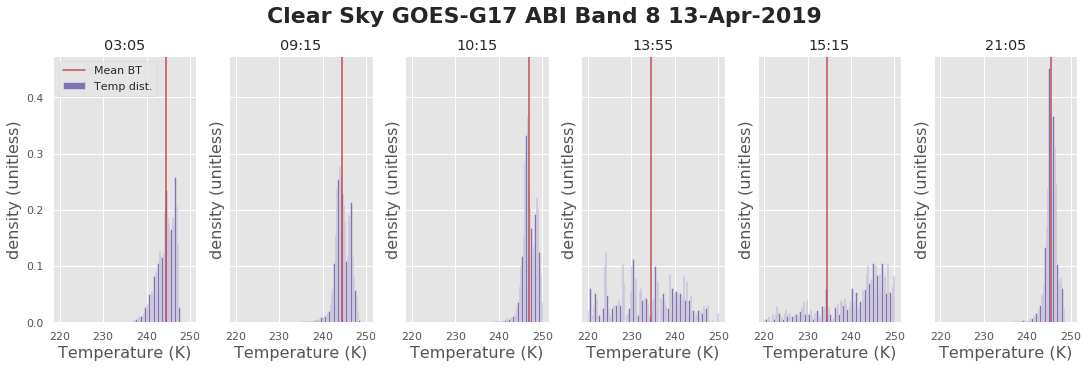

In [64]:
# Still need to make this a function
# two mysteries
# Why are there bars and ghost bars behind the bars???
# Why don't I get blue on one fig and magenta on the other???

# Histograms for the cloud free part
#toi = ['0300','0910','1010','1350','1510','2100']
toi = ['030','091','101','135','151','210']
bb=8
dd=5
cfgoes_8_xr = {'G16':cfnew16_103_xr, 'G17':cfnew17_103_xr}
bins = np.linspace(220,260,101)
for SS in ['G16','G17']:
    bins = np.linspace(220,250,101)
    fig, axes = plt.subplots(ncols=6, nrows =1, figsize=(15, 5), 
                             constrained_layout=True, sharey = True, 
                             sharex = True)
    fig.suptitle(f'Clear Sky GOES-{SS} ABI Band {bb} {8+dd}-Apr-2019', 
                 fontsize = 22, fontweight = 'bold')
    cfrois = cfgoes_8_xr[SS].Rad[:,:,[(str(item.data)[:3] in toi)
                for item in goes_8_xr[SS].time.dt.strftime('%H%M')]]
    cfrois_sz = cfrois.shape
    for ind in range(cfrois_sz[2]):
        ax = axes[ind]
        ax.set_title(f'{ind}')
        ax.set_ylabel('density (unitless)',fontsize = 16)
        ax.set_xlabel('Temperature (K)', fontsize = 16)
        ax.set_title(rois[:,:,ind].time.dt.strftime('%H:%M').data)
        ax.hist(Rad2BT(cfrois[:,:,ind],plc).data.ravel(), 
                                            bins = bins,
                                            color='b' if SS=='16' else 'm',
                                           density = True, 
                                           label = 'Temp dist.')
        ax.axvline(Rad2BT(cfrois[:,:,ind].mean(['x','y']), plc), 
                   color='r',label = 'Mean BT')
    axes[0].legend(loc='upper left')

In [60]:
str(None)

'None'